In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal
from gdalconst import * 

import sys, os, time

from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image

from IPython.display import clear_output

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load data in GeoTiff format

Let's look at the VIIRS data of night lights. This data is acquired monthly and is available since 2012. The spatial resolution is $0.5 \ km^2/px$.
The data is provided as a set of 6 tiles that span most of the globe (two files per tile).

In [2]:
# list of files 

# files = """http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N180W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N060W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N060E_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N180W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N060W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N060E_vcmcfg_v10_c201610280941.tgz""".split("\n")

In [78]:
import glob, os
rast_files = glob.glob("/home/ubuntu/data/VIIRS/2016-09/*.avg_rade9.tif")
print len(rast_files)

6


In [18]:
loc = (37.7749, -122.4194) # San Francisco lat/lon

### Helper utilities

In [16]:
import sys
sys.path.append("../satimage-processing/")
import satimg 

Given a location (lat, lon) and a spatial area (width, height) in km, get the bounding box in degrees

In [19]:
bbox = satimg.bounding_box_at_location(loc, (100,100))
print bbox

(37.32517953888292, -122.98836144499806, 38.224620461117084, -121.85043855500192)


Get spatial dimensions of area (in degrees) at a given lat,lon location

In [20]:
geoSize = satimg.km_to_deg_at_location(loc, (100,100))
print geoSize

(0.899440922234163, 1.1379228899961475)


### Get images from from raster

Initialize client with either a raster file (GeoTiff format) or with a directory containing multiple such files. In the latter scenario, it is assumed that the files provide coverage of different geographical areas around the same time. 

In [79]:
# initialize client
simg = satimg.SatImage(rast_files)

When no spatial width is given, assume the desired output is the pixel value at that the input location.

In [80]:
pixValue = simg.get_image_at_location(loc)
pixValue

array([ 74.84559631])

Get image of a given spatial extent $w$ (in $km$) at a given location $loc=(lat, lon)$

In [82]:
img = simg.get_image_at_location(loc, w=100) # a 10km x 10km window around the geographical center of San Francisco
img.shape

(1, 273, 216)

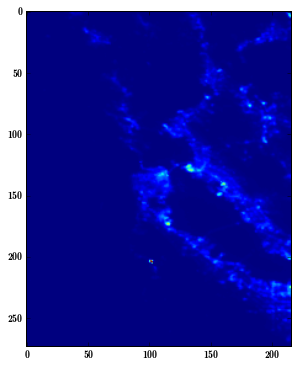

In [86]:
plt.figure(figsize=(8,6))
plt.imshow(img[0])

Obtain a few images for a number of cities around the world. Note that different locations may be in different raster files.

In [87]:
locs = ["San Francisco, CA", "Cambridge, MA", "Toronto, Canada", "Iasi, Romania", "Singapore", "Beijing, China"]

# obtaining the lat/lon coordinates via geocoding before the call is not needed

# import geocoder
# locs = [tuple(geocoder.google(l).latlng) for l in locs]
# locs

In [88]:
images = simg.get_image_at_locations(locs, w=100)

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certa

In [101]:
images.keys()

['Cambridge, MA',
 'Singapore',
 'Beijing, China',
 'Iasi, Romania',
 'Toronto, Canada',
 'San Francisco, CA']

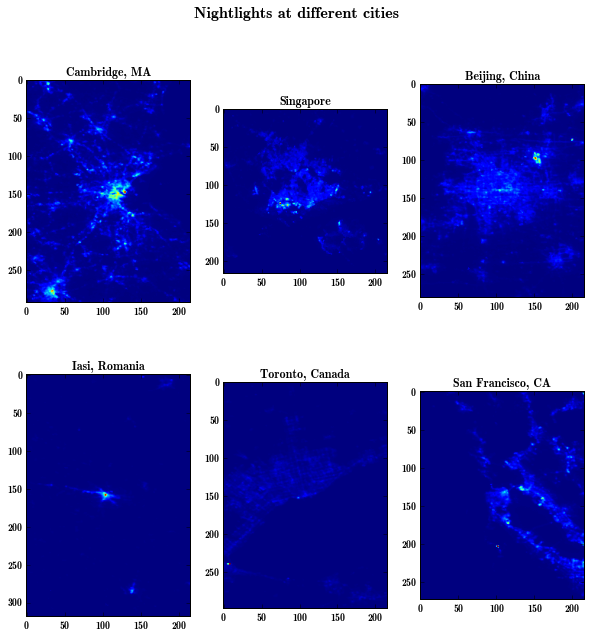

In [135]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Nightlights at different cities", fontsize=16)
for i,(k,v) in enumerate(images.iteritems()):
    ax = plt.subplot(2,3,i+1)
    ax.set_title(k)
    plt.imshow(v[0,:,:])
plt.show()

### Sample images around locations

Sample locations within a bounding box

In [108]:
bbox # 100km x 100km around San Francisco

(37.32517953888292,
 -122.98836144499806,
 38.224620461117084,
 -121.85043855500192)

In [109]:
sample_locs = satimg.generate_locations_within_bounding_box(bbox, nSamples = 10)
print sample_locs

[(38.10518449146268, -122.56336905281651), (37.766351881968959, -122.37657395523721), (37.764121923819083, -122.8528256676563), (37.447855534006415, -122.03059203831694), (38.134509895459438, -121.88368552030985), (38.029161746500904, -122.54737130489239), (38.168125745591418, -122.41098950556385), (37.704033640413797, -122.96393100094382), (38.03502037648714, -122.14150326902976), (38.076647093480098, -121.99442247281402)]


Sample locations within a given polygon

In [110]:
from shapely.geometry import Polygon, Point
p = Polygon([(bbox[1], bbox[0]), ([bbox[1], bbox[2]]), (([bbox[3], bbox[2]])), ([bbox[3], bbox[0]])])

In [111]:
satimg.generate_locations_within_polygon(p, 10)

[(-122.70122647539139, 38.060189574311245),
 (-121.97146412927711, 37.524785511123497),
 (-122.07961248783812, 38.017160630659077),
 (-122.68798134249327, 37.398120976274541),
 (-122.03203577240342, 37.357339981677036),
 (-122.16027430152575, 37.349247579833772),
 (-122.97465794191162, 37.630831366422669),
 (-122.84635550908374, 38.05059303514853),
 (-122.85554383403948, 38.190106727025132),
 (-122.06814057838983, 37.915176963896677)]

For San Francisco, sample 10km x 10km images within a 100km x 100km bounding box

In [115]:
sampleImages = simg.sample_images_around_location(loc, w=5, W=100, nSamples=10)

In [116]:
len(sampleImages)

10

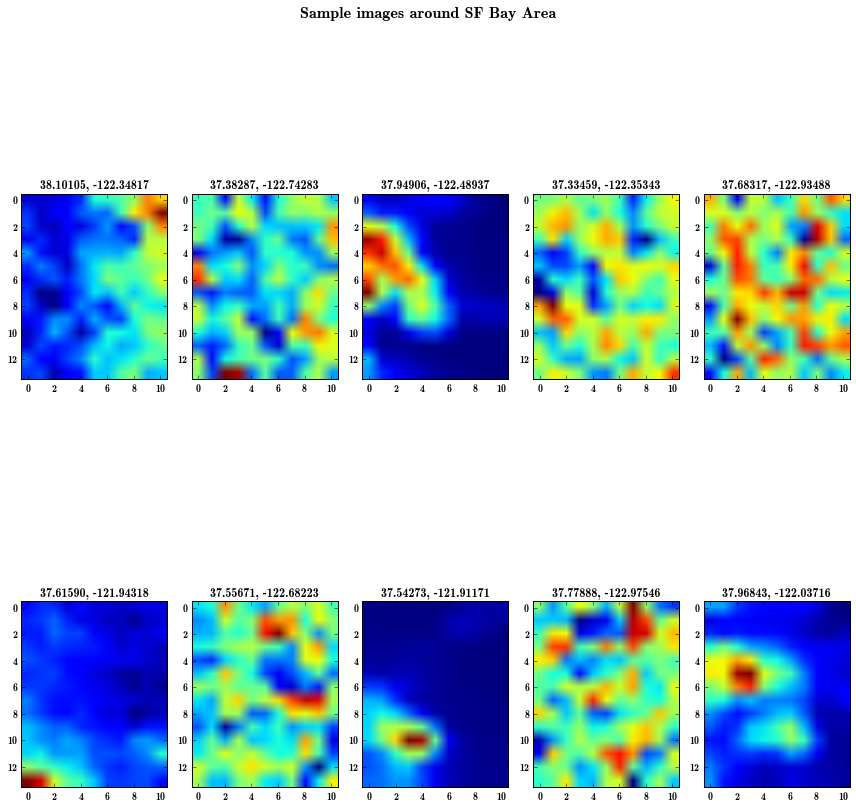

In [139]:
fig = plt.figure(figsize=(12,14))
fig.suptitle("Sample images around SF Bay Area", fontsize=16)
for i,(k,v) in enumerate(sampleImages.iteritems()):
    ax = plt.subplot(2,5,i+1)
    ax.set_title("%2.5f, %2.5f"%k)
    plt.imshow(v[0,:,:])
plt.tight_layout()
plt.show()

In [148]:
v.shape

(1, 14, 11)

In [152]:
v.reshape(v.shape[::-1]).shape

(11, 14, 1)

### Save sample images directly to file

Single image

In [160]:
simg.get_image_at_location(loc, w=100, dumpPath="./outpath/2016/")

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: ./outpath/2016//37.774900_-122.419400_100km.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Multiple images

In [161]:
locs

['San Francisco, CA',
 'Cambridge, MA',
 'Toronto, Canada',
 'Iasi, Romania',
 'Singapore',
 'Beijing, China']

In [164]:
simg.get_image_at_locations(locs, w=100, dumpPath="./outpath/2016/")

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: ./outpath/2016//37.774929_-122.419415_100km.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-pack

{'Beijing, China': None,
 'Cambridge, MA': None,
 'Iasi, Romania': None,
 'San Francisco, CA': None,
 'Singapore': None,
 'Toronto, Canada': None}

### Open raster data with rasterio
Rasterio is a neat package that supports more advanced manipulation of raster data. It may be worth looking at using it directly rather than barebones GDAL bindings in a future version of this module. 

In [113]:
import rasterio
from rasterio.tools.mask import mask

# the polygon GeoJSON geometry
geoms = [{'type': 'Polygon', 
          'coordinates': [[(bbox[1], bbox[0]), ([bbox[1], bbox[2]]), (([bbox[3], bbox[2]])), ([bbox[3], bbox[0]])]]}]

# load the raster, mask it by the polygon and crop it
src = rasterio.open(rast_files[1])
out_image, out_transform = mask(src, geoms, crop=True)
out_meta = src.meta.copy()

print out_image.data.sum()

# # save the resulting raster  
# out_meta.update({"driver": "GTiff",
#     "height": out_image.shape[1],
#     "width": out_image.shape[2],
# "transform": out_transform})

# with rasterio.open("masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)

327190.0


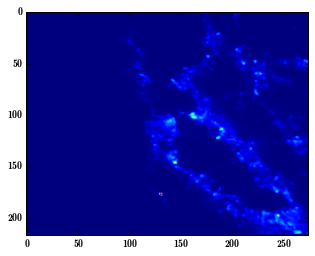

In [114]:
plt.imshow(out_image.data[0,:,:])